In [2]:
import os
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig
import torch
from scipy import spatial
from matplotlib import pyplot as plt

/scicore/home/schwede/pantol0000/mambaforge/envs/alphabeta/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
working_dir = '/scicore/home/schwede/pantol0000/repositories/alphabeta_classic'
scop_lookup_file = os.path.join(working_dir, 'data/scop_lookup.fix.tsv')
scop_fasta_file = os.path.join(working_dir, 'data/SCOPe40.fasta')

### Load sequences and labels

In [4]:
scop_sequences = dict()
with open(scop_lookup_file, 'r') as file:
    for line in file:
        seq_id,label = line.split()
        scop_sequences[seq_id] = {'label':label, 'seq':'', 'emb':0} 

In [5]:
with open(scop_fasta_file, 'r') as file:
    seq_id = ''
    for line in file:
        if line[0]=='>':
            seq_id = line[1:].strip()
        else:
            scop_sequences[seq_id]['seq'] = line.strip()

In [6]:
for i in scop_sequences:
    if scop_sequences[i]['seq']=='':
        print(f'Missing sequence {i}')

In [114]:
scop_sequences['d1xmta_']

{'label': 'd.108.1.1',
 'seq': 'PPKIVWNEGKRRFETEDHEAFIEYKMRNNGKVMDLVHTYVPSFKRGLGLASHLCVAAFEHASSHSISIIPSCSYVSDTFLPRNPSWKPLIHSEVF',
 'emb': 0}

In [ ]:
### Get few positive examples: 'a.1.1.1'

In [8]:
EMBEDDING_CONFIG = LogitsConfig(
    sequence=True, return_embeddings=True, return_hidden_states=True
)

In [10]:
client = ESMC.from_pretrained("esmc_300m").to("cpu")
a111_seq = dict()
for i in scop_sequences:
    if scop_sequences[i]['label'] == 'a.1.1.1': # or scop_sequences[i]['label'] == 'a.7.3.1' or scop_sequences[i]['label']=='d.108.1.1':
        protein = ESMProtein(scop_sequences[i]['seq'])
        protein_tensor = client.encode(protein ) 
        logits_output = client.logits(protein_tensor,EMBEDDING_CONFIG)
        
        a111_seq[i] = scop_sequences[i]
        a111_seq[i]['logits'] = logits_output.logits
        a111_seq[i]['emb']= logits_output.embeddings
        
        print(scop_sequences[i]['seq'])

Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 270.34it/s]
/scicore/home/schwede/pantol0000/mambaforge/envs/alphabeta/lib/python3.11/site-packages/esm/pretrained.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any

SLFEQLGGQAAVQAVTAQFYANIQADATVATFFNGIDMPNQTNKTAAFLCAALGGPNAWTGRNLKEVHANMGVSNAQFTTVIGHLRSALTGAGVAAALVEQTVAVAETVRGDVVTV
GLLSRLRKREPISIYDKIGGHEAIEVVVEDFFVRVLADDQLSAFFSGTNMSRLKGKQVEFFAAALGGPEPYTGAPMKQVHQGRGITMHHFSLVAGHLADALTAAGVPSETITEILGVIAPLAVDVTS
KSFYDAVGGAKTFDAIVSRFYAQVAEDEVLRRVYPEDDLAGAEERLRMFLEQYWGGPRTYSEQRGHPRLRMRHAPFRISLIERDAFLRCMHTAVASIDSETLDDEHRRELLDYLEMAAHSLVNSPF
STLYEKLGGTTAVDLAVDKFYERVLQDDRIKHFFADVDMAKQRAHQKAFLTYAFGGTDKYDGRYMREAHKELVENHGLNGEHFDAVAEDLLATLKEMGVPEDLIAEVAAVAGAPAHKRDVLNQ
EQWQTLYEAIGGEETVAKLVEAFYRRVAAHPDLRPIFPDDLTETAHKQKQFLTQYLGGPPLYTAEHGHPMLRARHLRFEITPKRAEAWLACMRAAMDEIGLSGPAREQFYHRLVLTAHHMVNTPDHLD


In [11]:
a111_seq.keys()

dict_keys(['d1dlwa_', 'd2gkma_', 'd2qrwa_', 'd1s69a_', 'd2bkma_'])

In [25]:
a111_seq['d1dlwa_']['emb'][0][1:-1].shape

torch.Size([116, 960])

In [19]:
len(a111_seq['d1dlwa_']['seq'])

116

In [18]:
a111_seq['d1dlwa_']['logits'].sequence.shape

torch.Size([1, 118, 64])

In [14]:
len(a111_seq['d1dlwa_']['seq'])

116

In [ ]:
def compute_cosine_similarity_matrix_plain(embedding1, embedding2):
    """ Take as input 2 sequence embeddings (at a residue level) and returns the cosine
        similarity matrix.

        :param embedding1: residues embedding representation for sequence 1
        :param embedding2: residues embedding representation for sequence 2

        :type embedding1: pytorch tensor
        :type embedding2: pytorch tensor
    """
    
    return torch.tensor(1-spatial.distance.cdist(embedding1.cpu().numpy(), embedding2.cpu().numpy(), 'cosine'))


In [14]:
### show sim matrix

In [116]:
for i in a111_seq:
    print(i, a111_seq[i]['label'])

d1dlwa_ a.1.1.1
d2gkma_ a.1.1.1
d2qrwa_ a.1.1.1
d1s69a_ a.1.1.1
d2bkma_ a.1.1.1
d1jnra1 a.7.3.1
d1kf6a1 a.7.3.1
d2bs2a1 a.7.3.1
d1chua1 a.7.3.1
d1neka1 a.7.3.1
d1m4ia_ d.108.1.1
d1bo4a_ d.108.1.1
d1n71a_ d.108.1.1
d1s3za_ d.108.1.1
d1z4ra1 d.108.1.1
d2b5ga_ d.108.1.1
d1i12a_ d.108.1.1
d1boba_ d.108.1.1
d2p0wa_ d.108.1.1
d1qsma_ d.108.1.1
d1xmta_ d.108.1.1
d2aj6a1 d.108.1.1
d1xeba_ d.108.1.1
d1yrea1 d.108.1.1
d2j8ma_ d.108.1.1
d2gana1 d.108.1.1
d1wwza1 d.108.1.1
d1yk3a1 d.108.1.1
d1y7ra1 d.108.1.1
d1r57a_ d.108.1.1
d2d4pa1 d.108.1.1
d1mk4a_ d.108.1.1
d1yx0a1 d.108.1.1
d1y9ka1 d.108.1.1
d1p0ha_ d.108.1.1
d2fsra1 d.108.1.1
d2g3aa1 d.108.1.1
d2ge3a1 d.108.1.1
d1y9wa1 d.108.1.1
d2fiaa1 d.108.1.1
d2euia1 d.108.1.1
d2atra1 d.108.1.1
d2cy2a1 d.108.1.1
d1nsla_ d.108.1.1
d2jdca1 d.108.1.1
d1q2ya_ d.108.1.1
d2fe7a1 d.108.1.1
d2fiwa1 d.108.1.1
d2fl4a1 d.108.1.1
d1tiqa_ d.108.1.1
d2ae6a1 d.108.1.1
d1u6ma_ d.108.1.1
d2i6ca1 d.108.1.1
d1vkca_ d.108.1.1
d1ufha_ d.108.1.1
d1vhsa_ d.108.1.1
d2fcka1 d.10

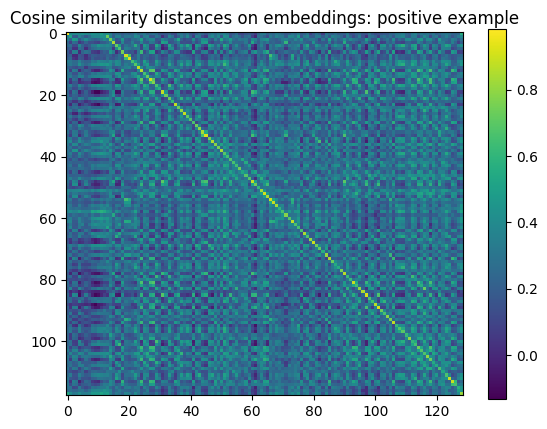

In [80]:
sm = compute_cosine_similarity_matrix_plain(a111_seq['d1dlwa_']['emb'].squeeze(), a111_seq['d2gkma_']['emb'].squeeze())
plt.imshow(sm)
plt.title('Cosine similarity distances on embeddings: positive example')
plt.colorbar()

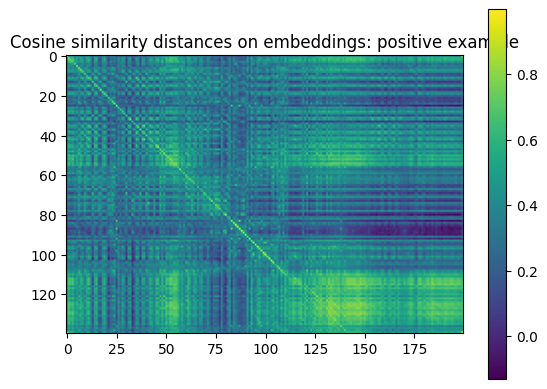

In [112]:
sm = compute_cosine_similarity_matrix_plain(a111_seq['d1neka1']['emb'].squeeze(), a111_seq['d2bs2a1']['emb'].squeeze())
plt.imshow(sm)
plt.title('Cosine similarity distances on embeddings: positive example')
plt.colorbar()

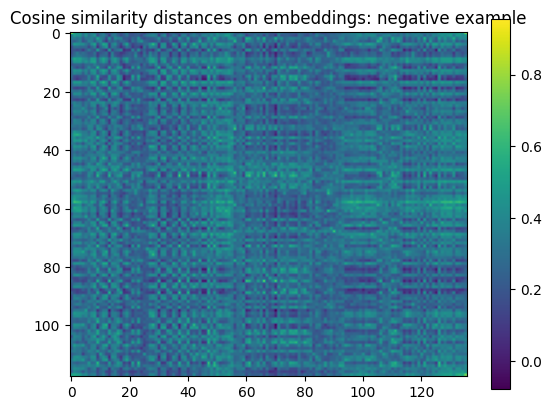

In [82]:
sm = compute_cosine_similarity_matrix_plain(a111_seq['d1dlwa_']['emb'].squeeze(), a111_seq['d1kf6a1']['emb'].squeeze())
plt.imshow(sm)
plt.title('Cosine similarity distances on embeddings: negative example')
plt.colorbar()

In [39]:
### Run kmeans only on proteins in a111

In [83]:
from scipy.cluster.vq import kmeans2

In [84]:
tensor_list = [a111_seq[seq_id]['emb'].squeeze() for seq_id in a111_seq]
data_landscape = torch.cat(tensor_list, dim=0)
data_landscape.shape

torch.Size([1362, 960])

In [101]:
alphabet_size = 20
codebook_20,labels_20 = kmeans2(data_landscape, alphabet_size, minit='points')

In [102]:
alphabet_size = 40
codebook_40,labels_40 = kmeans2(data_landscape, alphabet_size, minit='points')

In [103]:
alphabet_size = 200
codebook_200,labels_200 = kmeans2(data_landscape, alphabet_size, minit='points')

In [ ]:
### subsitute to each embedding the closest codebook

In [104]:
prev_seq_length = 0
for idx,i in enumerate(a111_seq):
    seq_length = len(a111_seq[i]['seq'])

    seq_codebook = [torch.tensor(codebook_20[i]).unsqueeze(dim=0) for i in labels_20[prev_seq_length:prev_seq_length+seq_length]]
    a111_seq[i]['ab_20'] = torch.cat(seq_codebook, dim=0)

    seq_codebook = [torch.tensor(codebook_40[i]).unsqueeze(dim=0) for i in labels_40[prev_seq_length:prev_seq_length+seq_length]]
    a111_seq[i]['ab_40'] = torch.cat(seq_codebook, dim=0)

    seq_codebook = [torch.tensor(codebook_200[i]).unsqueeze(dim=0) for i in labels_200[prev_seq_length:prev_seq_length+seq_length]]
    a111_seq[i]['ab_200'] = torch.cat(seq_codebook, dim=0)
    prev_seq_length = seq_length

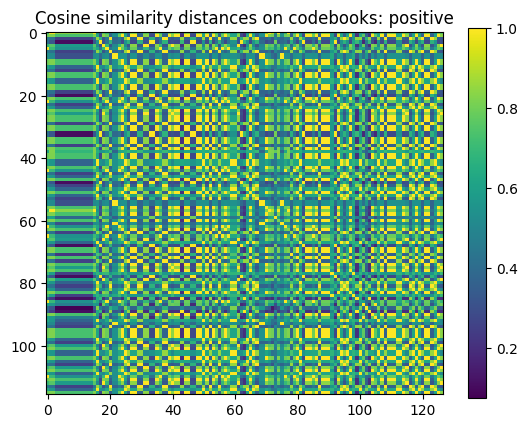

In [105]:
sm = compute_cosine_similarity_matrix_plain(a111_seq['d1dlwa_']['ab'], a111_seq['d2gkma_']['ab'])
plt.imshow(sm)
plt.title('Cosine similarity distances on codebooks: positive')
plt.colorbar()

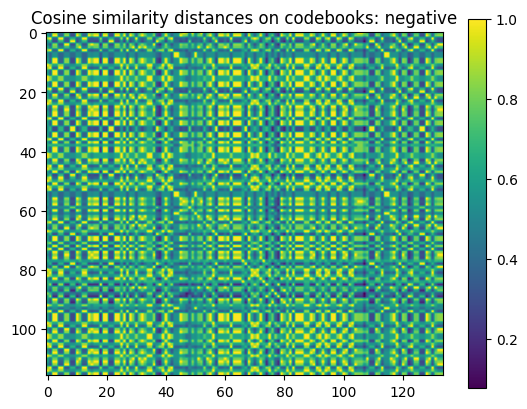

In [106]:
sm = compute_cosine_similarity_matrix_plain(a111_seq['d1dlwa_']['ab'], a111_seq['d1kf6a1']['ab'])
plt.imshow(sm)
plt.title('Cosine similarity distances on codebooks: negative')
plt.colorbar()

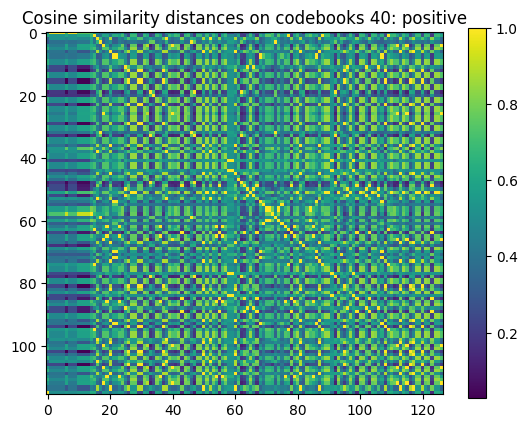

In [107]:
sm = compute_cosine_similarity_matrix_plain(a111_seq['d1dlwa_']['ab_40'], a111_seq['d2gkma_']['ab_40'])
plt.imshow(sm)
plt.title('Cosine similarity distances on codebooks 40: positive')
plt.colorbar()

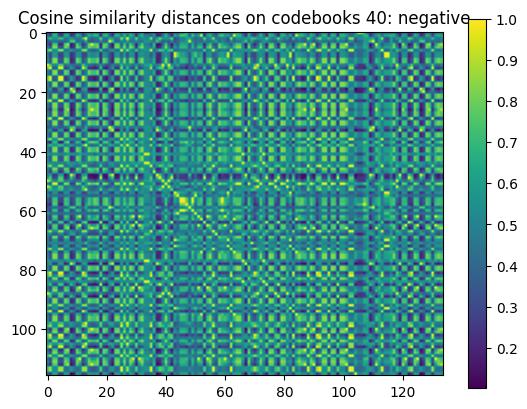

In [108]:
sm = compute_cosine_similarity_matrix_plain(a111_seq['d1dlwa_']['ab_40'], a111_seq['d1kf6a1']['ab_40'])
plt.imshow(sm)
plt.title('Cosine similarity distances on codebooks 40: negative')
plt.colorbar()

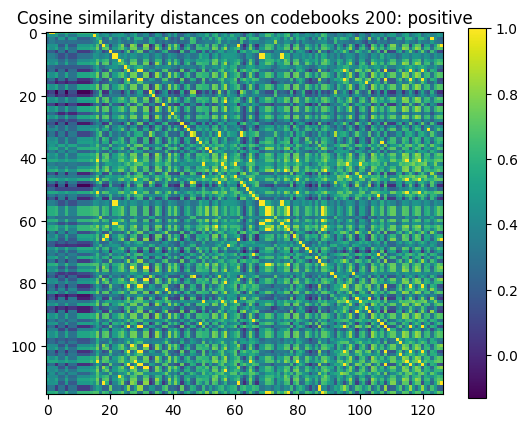

In [109]:
sm = compute_cosine_similarity_matrix_plain(a111_seq['d1dlwa_']['ab_200'], a111_seq['d2gkma_']['ab_200'])
plt.imshow(sm)
plt.title('Cosine similarity distances on codebooks 200: positive')
plt.colorbar()

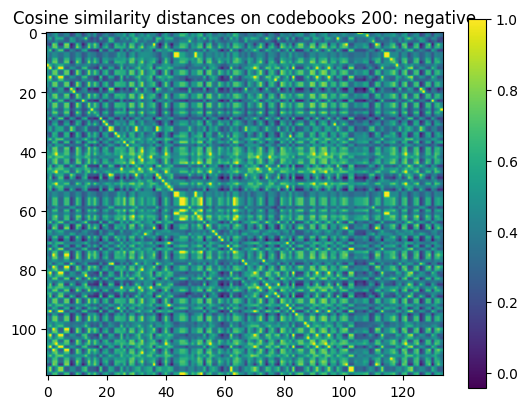

In [110]:
sm = compute_cosine_similarity_matrix_plain(a111_seq['d1dlwa_']['ab_200'], a111_seq['d1kf6a1']['ab_200'])
plt.imshow(sm)
plt.title('Cosine similarity distances on codebooks 200: negative')
plt.colorbar()

In [90]:
### codebook usage
characters = dict()
for i in labels_20:
    if i not in characters.keys():
        characters[i] = 0
    characters[i] += 1

In [91]:
characters

{6: 79,
 16: 133,
 5: 117,
 12: 50,
 2: 95,
 1: 96,
 10: 35,
 19: 75,
 13: 93,
 17: 32,
 15: 34,
 4: 66,
 7: 50,
 0: 14,
 18: 33,
 8: 39,
 14: 105,
 3: 38,
 9: 96,
 11: 82}